In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from statsmodels.tsa.seasonal import STL
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

# Visualization settings
sns.set_theme(style="whitegrid")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['svg.fonttype'] = 'none'  # 确保SVG中的文字可编辑

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

file_path = 'Data2/data2024.csv'
data = pd.read_csv(file_path)
data = data.interpolate(method='linear').fillna(0)
# columns = data.columns[1:]
columns = data.columns
X = data[columns].values

Using device: cpu


In [4]:
np.shape(X)
print(np.shape(X))
print(X)

(6576, 10)
[[  7.75632861  31.54964926  15.01166111 ...   9.12526378 158.0576377
    1.56115429]
 [  7.75044889  31.54867936  21.750625   ...   9.04768607 118.6816897
    1.1853515 ]
 [  7.75553191  31.53102078  18.08460864 ...   9.0828382  205.2890777
    0.4301798 ]
 ...
 [  8.81524861  31.48932571   2.84571667 ...   7.01764834 140.4052061
    0.31275738]
 [  8.78903667  31.43635975   6.04832778 ...   7.000717   168.864048
    0.61964833]
 [  8.73361861  31.32077825  10.69146945 ...   6.87505834 154.3727632
    0.57574728]]


C:\Users\11389\Desktop\CAM_T\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25552 (\N{CJK UNIFIED IDEOGRAPH-63D0}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\11389\Desktop\CAM_T\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21462 (\N{CJK UNIFIED IDEOGRAPH-53D6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\11389\Desktop\CAM_T\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\11389\Desktop\CAM_T\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32508 (\N{CJK UNIFIED IDEOGRAPH-7EFC}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\11389\Desktop\CAM_T\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missi

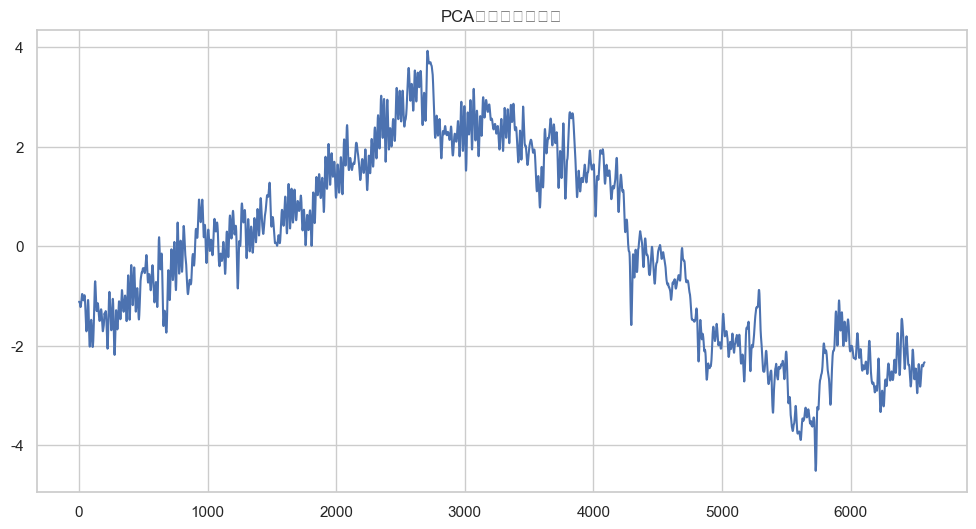

C:\Users\11389\Desktop\CAM_T\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21021 (\N{CJK UNIFIED IDEOGRAPH-521D}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\11389\Desktop\CAM_T\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\11389\Desktop\CAM_T\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\11389\Desktop\CAM_T\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\11389\Desktop\CAM_T\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missi

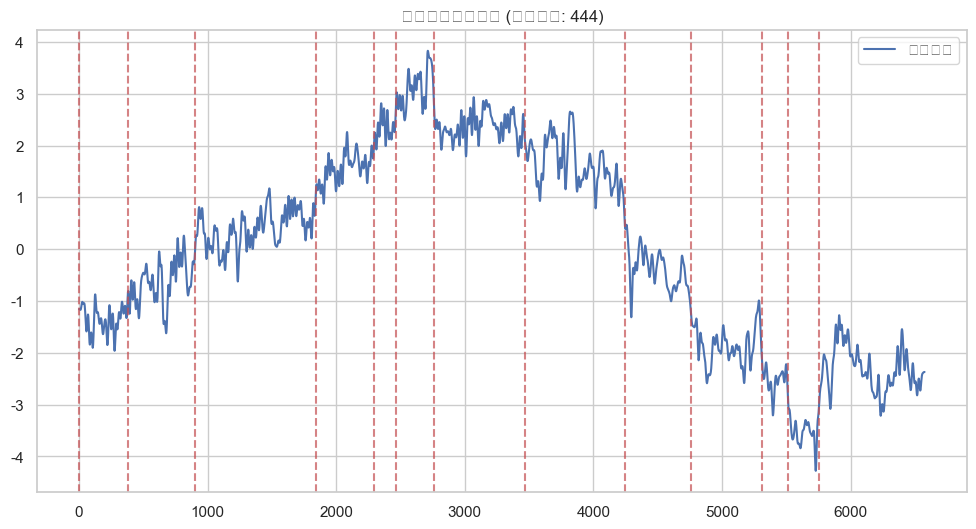

In [5]:

# STL趋势提取
trends = []
for col in range(X.shape[1]):
    series = pd.Series(X[:, col])
    stl = STL(series, period=12)
    result = stl.fit()
    trends.append(result.trend)

# PCA降维
trend_matrix = np.array(trends).T
trend_matrix_std = (trend_matrix - trend_matrix.mean(axis=0)) / trend_matrix.std(axis=0)
pca = PCA(n_components=1)
overall_trend = pca.fit_transform(trend_matrix_std).flatten()

# 可视化趋势
plt.figure(figsize=(12, 6))
plt.plot(overall_trend, label='综合趋势')
plt.title("PCA提取的综合趋势")
plt.show()

series = pd.Series(overall_trend, index=data.index)
stl = STL(series, period=12)
result = stl.fit()
trend_array = result.trend.values
trend = result.trend


# PELT变点检测
def normal_meanvar(data):
    data = np.hstack(([0.0], np.array(data)))

    cumm = np.cumsum(data)
    cumm_sq = np.cumsum([val ** 2 for val in data])

    def cost(s, t):
        ts_i = 1.0 / (t - s)
        mu = (cumm[t] - cumm[s]) * ts_i
        sig = (cumm_sq[t] - cumm_sq[s]) * ts_i - mu ** 2
        sig = max(sig, 1e-10)
        sig_i = 1.0 / sig
        return (t - s) * np.log(sig) + (cumm_sq[t] - cumm_sq[s]) * sig_i - 2 * (cumm[t] - cumm[s]) * mu * sig_i + (
                (t - s) * mu ** 2) * sig_i

    return cost


def find_min(arr, val=0.0):
    return min(arr) + val, np.argmin(arr)


def pelt(cost, length, pen=None):
    if pen is None:
        pen = np.log(length)

    F = np.zeros(length + 1)
    R = np.array([0], dtype=np.int64)
    candidates = np.zeros(length + 1, dtype=np.int64)

    F[0] = -pen

    for tstar in range(2, length + 1):
        cpt_cands = R
        seg_costs = np.zeros(len(cpt_cands))
        for i in range(0, len(cpt_cands)):
            seg_costs[i] = cost(cpt_cands[i], tstar)

        F_cost = F[cpt_cands] + seg_costs
        F[tstar], tau = find_min(F_cost, pen)
        candidates[tstar] = cpt_cands[tau]

        ineq_prune = [val < F[tstar] for val in F_cost]
        R = [cpt_cands[j] for j, val in enumerate(ineq_prune) if val]
        R.append(tstar - 1)
        R = np.array(R, dtype=np.int64)

    last = candidates[-1]
    changepoints = [last]
    while last > 0:
        last = candidates[last]
        changepoints.append(last)

    return sorted(changepoints)


# 执行检测
cost_function = normal_meanvar(trend_array)
penalty = 444
change_points = pelt(cost_function, len(trend_array), penalty)

# 可视化变点
plt.figure(figsize=(12, 6))
plt.plot(result.trend, label='趋势成分')
for cp in change_points:
    plt.axvline(x=trend.index[cp], color='r', linestyle='--', alpha=0.7)
plt.title(f'初始变点检测结果 (惩罚参数: {penalty})')
plt.legend()
plt.show()

In [5]:
print(X.shape[1])

10


C:\Users\3148\.conda\envs\NGC\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35843 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\3148\.conda\envs\NGC\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 25972 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\3148\.conda\envs\NGC\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21518 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\3148\.conda\envs\NGC\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\3148\.conda\envs\NGC\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26102 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\3148\.conda\envs\NGC\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarni

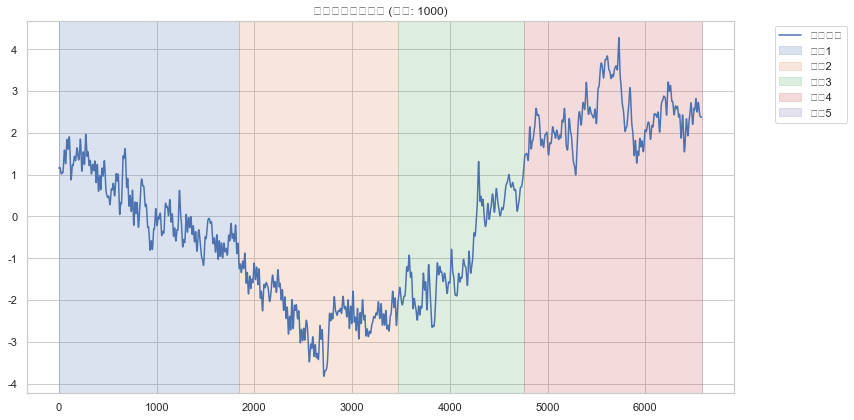

最终窗口划分:
窗口 1: 起点=0, 终点=1841, 长度=1841
窗口 2: 起点=1841, 终点=3471, 长度=1630
窗口 3: 起点=3471, 终点=4757, 长度=1286
窗口 4: 起点=4757, 终点=6575, 长度=1818
窗口 5: 起点=6575, 终点=6575, 长度=0


In [7]:

threshold = 1000
change_points = [0] + change_points + [len(trend) - 1]
segments = []

i = 0
while i < len(change_points) - 1:
    start = change_points[i]
    end = change_points[i + 1]
    while (end - start) < threshold and i < len(change_points) - 2:
        i += 1
        end = change_points[i + 1]
    segments.append((start, end))
    i += 1

# 可视化最终窗口
plt.figure(figsize=(12, 6))
plt.plot(result.trend, label='趋势成分')
for i, (s, e) in enumerate(segments):
    plt.axvspan(trend.index[s], trend.index[e], alpha=0.2, color=f'C{i}',
                label=f'窗口{i + 1}' if i < 5 else None)
plt.title(f'调整后的时间窗口 (阈值: {threshold})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("最终窗口划分:")
for i, (s, e) in enumerate(segments):
    print(f"窗口 {i + 1}: 起点={s}, 终点={e}, 长度={e - s}")


In [8]:

class NeuralGrangerSingle(nn.Module):
    def __init__(self, num_series, num_lags, hidden_size):
        super().__init__()
        self.input_size = num_series * num_lags
        self.hidden = nn.Linear(self.input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        return self.output(self.relu(self.hidden(x)))


def analyze_window(window_data, num_lags=10, hidden_size=20, num_epochs=100):
    """执行单个窗口的分析并保存数据"""
    # 数据标准化
    scaler = StandardScaler()
    data_norm = scaler.fit_transform(window_data)

    # 创建滞后数据
    X, Y = [], []
    for t in range(num_lags, len(data_norm)):
        X.append(data_norm[t - num_lags:t].flatten())
        Y.append(data_norm[t])
    X, Y = np.array(X), np.array(Y)

    # 转换为Tensor
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    Y_tensor = torch.tensor(Y, dtype=torch.float32).to(device)

    N = window_data.shape[1]
    causal_matrix = np.zeros((N, N))
    loss_history = []

    # 使用tqdm添加变量级进度条
    for target in tqdm(range(N), desc='Training variables', leave=False):
        # 模型初始化
        model = NeuralGrangerSingle(N, num_lags, hidden_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.MSELoss()

        # 数据加载
        dataset = torch.utils.data.TensorDataset(X_tensor, Y_tensor[:, target].unsqueeze(1))
        loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

        # 训练过程
        epoch_losses = []
        for epoch in range(num_epochs):
            batch_losses = []
            for batch_X, batch_Y in loader:
                optimizer.zero_grad()
                pred = model(batch_X)
                loss = criterion(pred, batch_Y)
                loss.backward()
                optimizer.step()
                batch_losses.append(loss.item())
            epoch_losses.append(np.mean(batch_losses))
        loss_history.append(epoch_losses)

        # 提取权重
        weights = model.hidden.weight.detach().cpu().numpy()
        for j in range(N):
            indices = [i * N + j for i in range(num_lags)]
            causal_matrix[target, j] = np.linalg.norm(weights[:, indices])

    # 归一化到0-1
    causal_min = causal_matrix.min()
    causal_max = causal_matrix.max()
    causal_matrix = (causal_matrix - causal_min) / (causal_max - causal_min + 1e-9)

    return causal_matrix, loss_history


In [9]:

# 创建保存结果的文件夹
os.makedirs("Data2_svg", exist_ok=True)

Training variables: 100%|██████████| 10/10 [00:57<00:00,  5.60s/it]
                                                                   

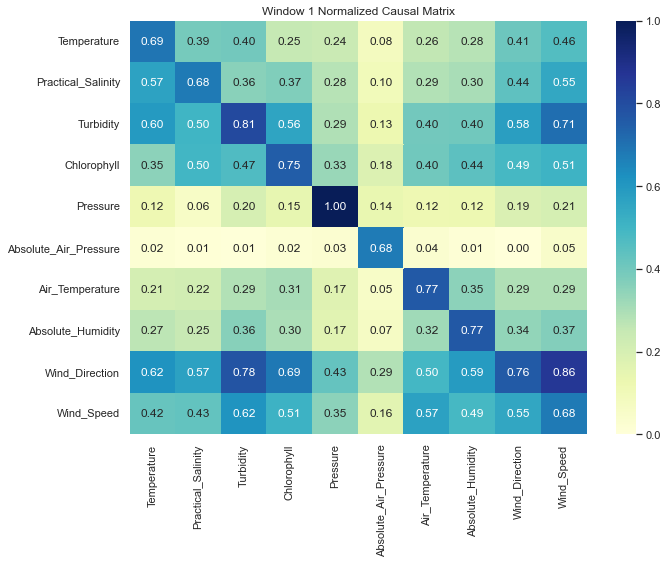

Training variables: 100%|██████████| 10/10 [00:50<00:00,  5.04s/it]
                                                                   

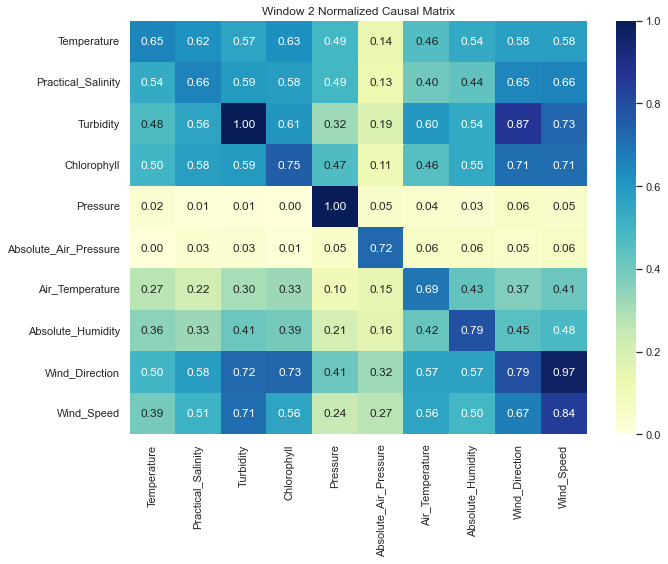

Training variables: 100%|██████████| 10/10 [00:40<00:00,  3.78s/it]
                                                                   

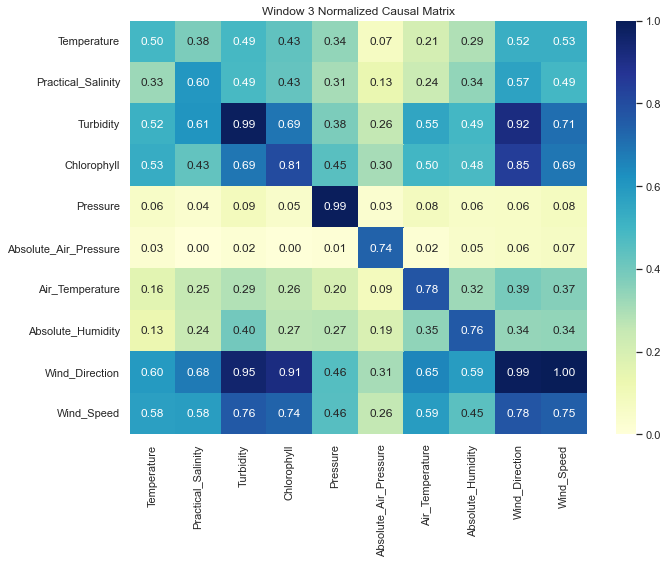

Training variables: 100%|██████████| 10/10 [00:56<00:00,  5.66s/it]
                                                                   

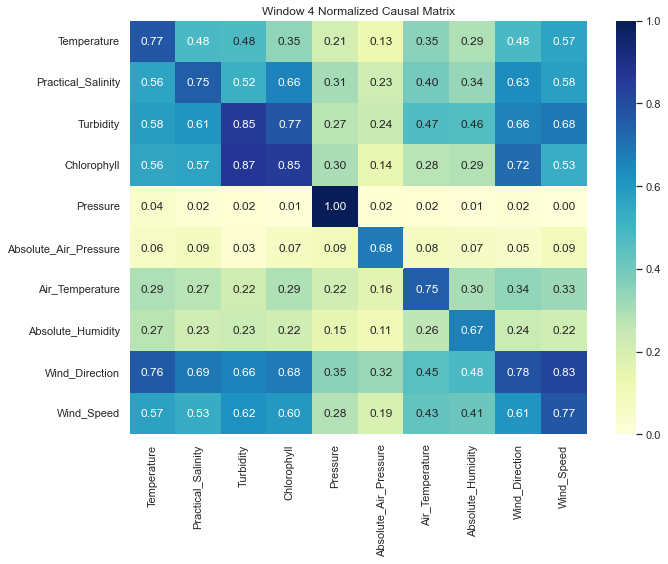

Analyzing windows: 100%|██████████| 5/5 [03:25<00:00, 41.17s/it, Window 5 Length=0]   


Window 5 too short (length=0), skipped

Final causal tensor shape: (4, 10, 10)
Results saved in 'analysis_svg' folder


In [10]:

causal_tensor = []
all_losses = []

# 使用嵌套进度条
with tqdm(enumerate(segments), total=len(segments), desc="Analyzing windows") as window_iter:
    for idx, (start, end) in window_iter:
        # 提取窗口数据
        window_data = data.iloc[start:end].values
#        window_data = data.iloc[start:end, 1:].values
        window_iter.set_postfix_str(f"Window {idx + 1} Length={end - start}")

        # 跳过短窗口
        if len(window_data) < 10:
            print(f"\nWindow {idx + 1} too short (length={end - start}), skipped")
            continue

        # 执行分析
        causal_matrix, _ = analyze_window(window_data)
        causal_tensor.append(causal_matrix)

        # 可视化因果矩阵
        plt.figure(figsize=(10, 8))
        sns.heatmap(causal_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
                    vmin=0, vmax=1,
                    xticklabels=columns,
                    yticklabels=columns)
        plt.title(f"Window {idx + 1} Normalized Causal Matrix")

        # 同时显示和保存
        plt.tight_layout()
        plt.savefig(f"analysis_svg/window_{idx + 1}_matrix.svg", format='svg')
        plt.show()  # 在Jupyter中显示

        # 关闭图形释放内存
        plt.close()
causal_tensor = np.stack(causal_tensor, axis=0)
print("\nFinal causal tensor shape:", causal_tensor.shape)
np.save("causal_tensor.npy", causal_tensor)
print("Results saved in 'analysis_svg' folder")


In [11]:
print(causal_tensor)
np.save("causal_tensor1.npy", causal_tensor)

[[[0.69475265 0.39321421 0.39843893 0.25119391 0.23947247 0.08402326
   0.26031008 0.28048484 0.4139928  0.46152057]
  [0.57028791 0.68053801 0.35836964 0.37495957 0.27809088 0.09953258
   0.28698689 0.30408047 0.43808871 0.54695486]
  [0.59522028 0.50355399 0.8094162  0.56220158 0.29281117 0.12840948
   0.40038199 0.40341985 0.58190903 0.70728066]
  [0.35265231 0.49654144 0.4717156  0.75069529 0.32865045 0.18146628
   0.40339331 0.44173337 0.49136566 0.50861528]
  [0.11901714 0.05926969 0.20034922 0.14578385 1.         0.14049661
   0.11912191 0.12313821 0.18839843 0.20653412]
  [0.0199326  0.01027458 0.00530351 0.0234238  0.02937064 0.6761497
   0.03510412 0.01305757 0.         0.04722255]
  [0.20711724 0.21511474 0.28666559 0.30621522 0.17291265 0.05468939
   0.76554025 0.35221124 0.29009212 0.29122324]
  [0.2678968  0.24974091 0.36228756 0.3001552  0.16599307 0.06956458
   0.32019474 0.76821871 0.33998678 0.37107542]
  [0.62093631 0.57147086 0.77907055 0.68552852 0.42825404 0.28784

In [12]:
print(segments)

[(0, 1841), (1841, 3471), (3471, 4757), (4757, 6575), (6575, 6575)]


In [13]:
print(window_data)

[]


In [68]:
print(np.shape(window_data))

(882, 6)
